# Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import collections
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian
from scipy import integrate
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('df_t90.csv')
# Use read_csv function to read .csv file.

df.rename(columns={'Unnamed: 0': 'Original Index'}, inplace=True)
# Rename the column label of the 0th column in place.
df

Original Index  Condition  97.978962  102.490177  106.999212  111.503945  \
0                64         19    10102.0     11158.0     11344.0     10812.0   
1                65         19    10159.0     11287.0     11348.0     10781.0   
2                66         19    10117.0     11208.0     11439.0     10672.0   
3                67         19     9985.0     11216.0     11512.0     10879.0   
4                68         19    10114.0     11175.0     11290.0     10677.0   
..              ...        ...        ...         ...         ...         ...   
130             826         27    10346.0     11647.0     11938.0     11431.0   
131             827         27    10454.0     11656.0     11852.0     11580.0   
132             828         27    10586.0     11864.0     11839.0     11497.0   
133             829         27    10651.0     12107.0     12098.0     11426.0   
134             830         27    10432.0     11860.0     11936.0     11465.0   

     116.006503  120.506889  125.002982  129.494787  ...  2471.804494  \
0        9706.0      8684.0      8023.0      7333.0  ...         89.0   
1        9713.0      8683.0      7921.0      7460.0  ...        148.0   
2        9720.0      8698.0      7926.0      7355.0  ...         81.0   
3        9777.0      8944.0      8015.0      7189.0  ...         93.0   
4        9934.0      8812.0      7944.0      7264.0  ...        104.0   
..          ...         ...         ...         ...  ...          ...   
130     10574.0      9603.0      8925.0      7975.0  ...        103.0   
131     10637.0      9535.0      8703.0      8104.0  ...        106.0   
132     10598.0      9384.0      8804.0      7899.0  ...        156.0   
133     10600.0      9483.0      8821.0      7968.0  ...        130.0   
134     10592.0      9781.0      8591.0      8079.0  ...        117.0   

     2474.967750  2478.128159  2481.288962  2484.448537  2487.605270  \
0          159.0        160.0        177.0        218.0        158.0   
1          172.0        158.0        201.0        185.0        211.0   
2          165.0        147.0        155.0        175.0        236.0   
3          148.0        155.0        236.0        193.0        209.0   
4          169.0        169.0        223.0        148.0        242.0   
..           ...          ...          ...          ...          ...   
130        200.0        120.0        230.0        158.0        208.0   
131        190.0         99.0        153.0        190.0        179.0   
132        115.0        166.0        157.0        198.0        218.0   
133        173.0        188.0        209.0        204.0        210.0   
134         88.0         93.0        143.0        177.0        181.0   

     2490.762395  2493.916680  2497.066511  2500.218354  
0          192.0        178.0        121.0        216.0  
1          184.0        143.0        100.0        172.0  
2          202.0        220.0        143.0        195.0  
3          177.0        184.0        133.0        193.0  
4          156.0        179.0        141.0        214.0  
..           ...          ...          ...          ...  
130        204.0        143.0        147.0        144.0  
131        165.0        152.0        122.0        213.0  
132        179.0        203.0        148.0        217.0  
133        166.0        161.0        128.0        205.0  
134        241.0        171.0        110.0        195.0  

[135 rows x 639 columns]

# Test Plots and Baseline Correction

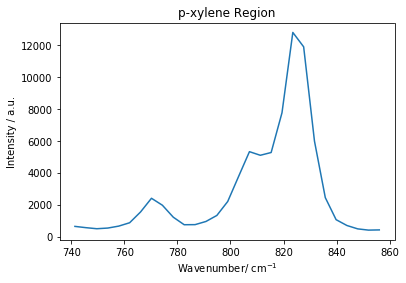

In [3]:
# Extract relevant p-xylene region and Vinyl region from the 1st spectra for
# baseline correction and plot tests.

pxyl_Region = df.iloc[0, 151:180] # Extract 1st spectra at the pxyl region and plot.
pxyl_Region.index = pxyl_Region.index.astype(float) # Change the index type to float.
pxyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
plt.show()

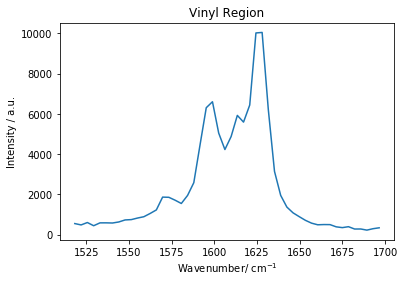

In [4]:
Vinyl_Region = df.iloc[0, 350:400] # Extract 1st spectra at the Vinyl region and plot.
Vinyl_Region.index = Vinyl_Region.index.astype(float) # Change the index type to float.
Vinyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
plt.show()

# Baseline Subtraction

## Custom

Choose two regions on the spectrum that you want to form the basis for the baseline. The spectrum is based on the truncated region of interest from the raw spectrum.

Choose from the curve above, <10 and >50 to form the x and y values to fit a polynomial line, serving as my baseline values. **Note that the x-axis is the placeholder index location of the truncated spectra, not the actual wavenumbers themselves**

p-xylene Region Baseline Subtraction

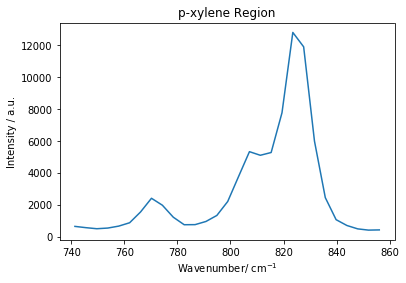

In [5]:
# p-xylene Region Baseline Subtraction
y = df.iloc[0, 151:180]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
y.plot()
plt.show()

# y is a Series. A pandas Series is a lablled/ indexed 1-D array. Therefore, a single argument of y,
# itself containing the intensity value (y-axis) at the corresponding wavenumber (x-axis) can be plotted. 

# Plot the 1st spectra (1st row) of df_t0.

In [6]:
xbl = [] # x-baseline.

for items in y.index[:5].values.tolist():
    xbl.append(items)

for items in y.index[25:].values.tolist():
    xbl.append(items)

# Recall that y is a Series with intensities labelled by their wavenumbers. y.index gives the Series labels, which are the 
# wavenumbers. y.index[:10] gives the 0th to 9th Series labels and is an index object. Convert the index object to a numpy
# array via y.index[:10].values, then put them into a list via y.index[:10].values.tolist().

# There are 2 for loops for the xbl (x baseline) list because you want the 1st 10 wavenumbers, but you also want the last
# wavenumbers from index 40 onwards. In the end, xbl is a single list containing all wavenumbers from index 0 to 9,
# and then from index 40 onwards. The same ideas apply for ybl, except for the fact that ybl contains intensities.

ybl = [] # y-baseline.

for items in y.values[:5].tolist():
    ybl.append(items)

for items in y.values[25:].tolist():
    ybl.append(items)
    
# y is a Pandas Series. Therefore, y.values immediately gives the values witihn that series, which are the intensities.

In [7]:
# Check that the range of xbl and ybl values makes sense.
xbl_and_ybl = list(zip(xbl, ybl))# Zip xbl and ybl together, then use list function to unpack the zipped object.
xbl_and_ybl

[(741.346779, 640.0),
 (745.475155, 560.0),
 (749.603622, 493.0),
 (753.730197, 535.0),
 (757.852903, 657.0),
 (843.890025, 696.0),
 (847.959811, 484.0),
 (852.027749, 406.0),
 (856.093841, 419.0)]

Running the baseline fit. **(x-values, y-values, polynomial degree)** are the arguments.

In [8]:
blpars = np.polyfit(xbl, ybl, 1)
# blpars contains the baseline parameters; the coefficients which will allow for the baseline polynomial to be defined.
# Fit a polynomial based on the x and y-values chosen for the spectra during the previous step. Thus, given a list of x values
# and its corresponding y-values, fit a polynomial through these points as best as you can. This polynomial will serve as the 
# baseline to be subtracted from the spectra's y-values. 
# numpy.polyfit(x, y, deg)
# np.polyfit: Least squares polynomial fit. Fit a polynomial p(x) = p[0] * x**deg + ... + p[deg] of degree deg to points (x, y).
# Returns a vector of coefficients p that minimises the squared error in the order deg, deg-1, … 0.
# Since degree = 1, we are fitting a straight line.

blfit = np.poly1d(blpars)
# A one-dimensional polynomial class. A convenience class, used to encapsulate “natural” operations on polynomials so that
# said operations may take on their customary form in code. blfit is a function that encompasses information on blpar's vector
# of coefficients derived from the np.polyfit step. It will take an input of x-values, then apply the coefficients to the
# x-values to obtain the best fit polynomial following the p(x) equation defined above.

Plot showing before and after subtraction.

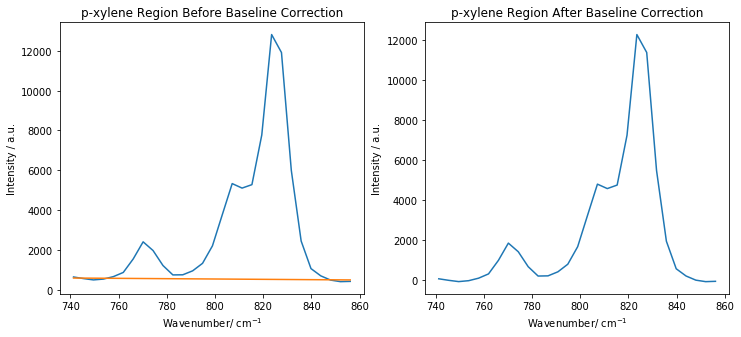

In [9]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1) # subplot(nrows, ncols, index)
plt.plot(y) # Plot the spectrum using the Series y.
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region Before Baseline Correction')
plt.plot(y.index, blfit(y.index))
# Plot the baseline polynomial to be subtracted (orange color). The x-axis will contain the wavenumbers. 
# Therefore y.index(Series labels) is being plotted at the x-axis. The y-axis will be blfit(y.index) because the output of 
# blfit(y.index) contains the y-values of the polynomial that is best fit to the input x-values.

plt.subplot(1,2,2)
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region After Baseline Correction')
plt.plot(y.index,(y - blfit(y.index)))
# Plot the baseline corrected spectrum. Subtraction can immediately be done because blfit(y.index) is a numpy array of y-values
# of the best fit polynomial. So the each value in Series y will minus each value in array blfit(y.index),
# to yield a final y value, which is the corrected spectra intensity. 

plt.show()

Vinyl Region Baseline Subtraction

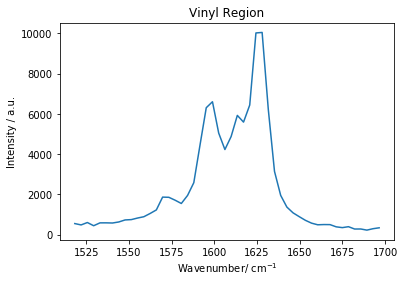

In [10]:
# Vinyl Region Baseline Subtraction
y = df.iloc[0, 350:400]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
y.plot()
plt.show()

In [11]:
xbl = []

for items in y.index[:10].values.tolist():
    xbl.append(items)

for items in y.index[40:].values.tolist():
    xbl.append(items)
    
ybl = []

for items in y.values[:10].tolist():
    ybl.append(items)

for items in y.values[40:].tolist():
    ybl.append(items)

In [12]:
xbl_and_ybl = list(zip(xbl, ybl))
xbl_and_ybl

[(1518.26751, 553.0),
 (1521.955154, 486.0),
 (1525.639408, 605.0),
 (1529.322087, 446.0),
 (1533.003193, 588.0),
 (1536.680916, 589.0),
 (1540.358881, 581.0),
 (1544.033465, 633.0),
 (1547.704672, 733.0),
 (1551.376124, 750.0),
 (1664.14117, 504.0),
 (1667.747082, 501.0),
 (1671.349689, 391.0),
 (1674.952563, 352.0),
 (1678.550353, 398.0),
 (1682.14841, 282.0),
 (1685.743172, 284.0),
 (1689.336421, 228.0),
 (1692.928159, 298.0),
 (1696.518387, 343.0)]

In [13]:
blpars = np.polyfit(xbl, ybl, 1)
blfit = np.poly1d(blpars)

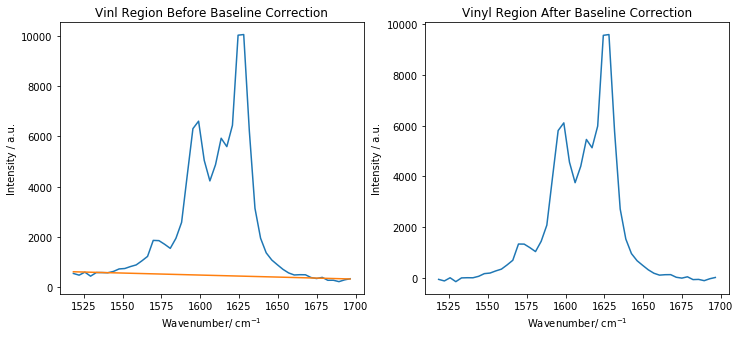

In [14]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.plot(y)
plt.plot(y.index, blfit(y.index))
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinl Region Before Baseline Correction')

plt.subplot(1,2,2)
plt.plot(y.index,(y - blfit(y.index))) 
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region After Baseline Correction')

plt.show()

# Fitting Functions

In [15]:
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian

def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']))
    
    return model - y

# Running Curve Fits

In [16]:
df_vinyl = df.iloc[:, 350:400].copy()
df_vinyl.columns = df_vinyl.columns.astype('float')
df_vinyl

1518.267510  1521.955154  1525.639408  1529.322087  1533.003193  \
0          553.0        486.0        605.0        446.0        588.0   
1          507.0        443.0        548.0        465.0        634.0   
2          462.0        513.0        539.0        504.0        551.0   
3          473.0        475.0        636.0        559.0        572.0   
4          443.0        515.0        509.0        517.0        572.0   
..           ...          ...          ...          ...          ...   
130        475.0        467.0        540.0        476.0        607.0   
131        485.0        475.0        572.0        519.0        596.0   
132        475.0        492.0        599.0        491.0        540.0   
133        435.0        379.0        532.0        508.0        568.0   
134        511.0        475.0        544.0        479.0        650.0   

     1536.680916  1540.358881  1544.033465  1547.704672  1551.376124  ...  \
0          589.0        581.0        633.0        733.0        750.0  ...   
1          603.0        589.0        648.0        716.0        744.0  ...   
2          612.0        575.0        663.0        690.0        711.0  ...   
3          635.0        606.0        581.0        678.0        697.0  ...   
4          608.0        646.0        530.0        673.0        681.0  ...   
..           ...          ...          ...          ...          ...  ...   
130        663.0        657.0        764.0        793.0        837.0  ...   
131        642.0        652.0        662.0        786.0        801.0  ...   
132        582.0        726.0        721.0        842.0        855.0  ...   
133        622.0        669.0        733.0        777.0        783.0  ...   
134        570.0        646.0        715.0        772.0        797.0  ...   

     1664.141170  1667.747082  1671.349689  1674.952563  1678.550353  \
0          504.0        501.0        391.0        352.0        398.0   
1          504.0        465.0        443.0        379.0        364.0   
2          433.0        467.0        411.0        342.0        323.0   
3          522.0        455.0        414.0        349.0        390.0   
4          469.0        426.0        387.0        319.0        326.0   
..           ...          ...          ...          ...          ...   
130        600.0        579.0        467.0        434.0        448.0   
131        608.0        457.0        468.0        439.0        376.0   
132        595.0        592.0        438.0        407.0        447.0   
133        570.0        463.0        390.0        409.0        428.0   
134        535.0        556.0        487.0        397.0        321.0   

     1682.148410  1685.743172  1689.336421  1692.928159  1696.518387  
0          282.0        284.0        228.0        298.0        343.0  
1          307.0        270.0        275.0        273.0        317.0  
2          288.0        293.0        305.0        271.0        291.0  
3          292.0        312.0        300.0        217.0        282.0  
4          281.0        269.0        241.0        242.0        268.0  
..           ...          ...          ...          ...          ...  
130        299.0        312.0        251.0        264.0        291.0  
131        243.0        301.0        294.0        292.0        265.0  
132        354.0        308.0        286.0        286.0        266.0  
133        310.0        342.0        336.0        296.0        289.0  
134        330.0        298.0        334.0        257.0        369.0  

[135 rows x 50 columns]

For 2 Lorentzians peak fits within the region of interest:

## Select initial guess parameters, namely amplitude, centre, width of the peaks.

In [17]:
ampL1 = 100000 # Peak Amplitude of 1st Peak
cenL1 = 1599 # Peak location of 1st Peak
widL1 = 10

ampL2 = 100000 # Peak Amplitude of 2nd Peak
cenL2 = 1627 # Peak location of 2nd Peak
widL2 = 6

## Fitting and Plotting (Vinyl Region)

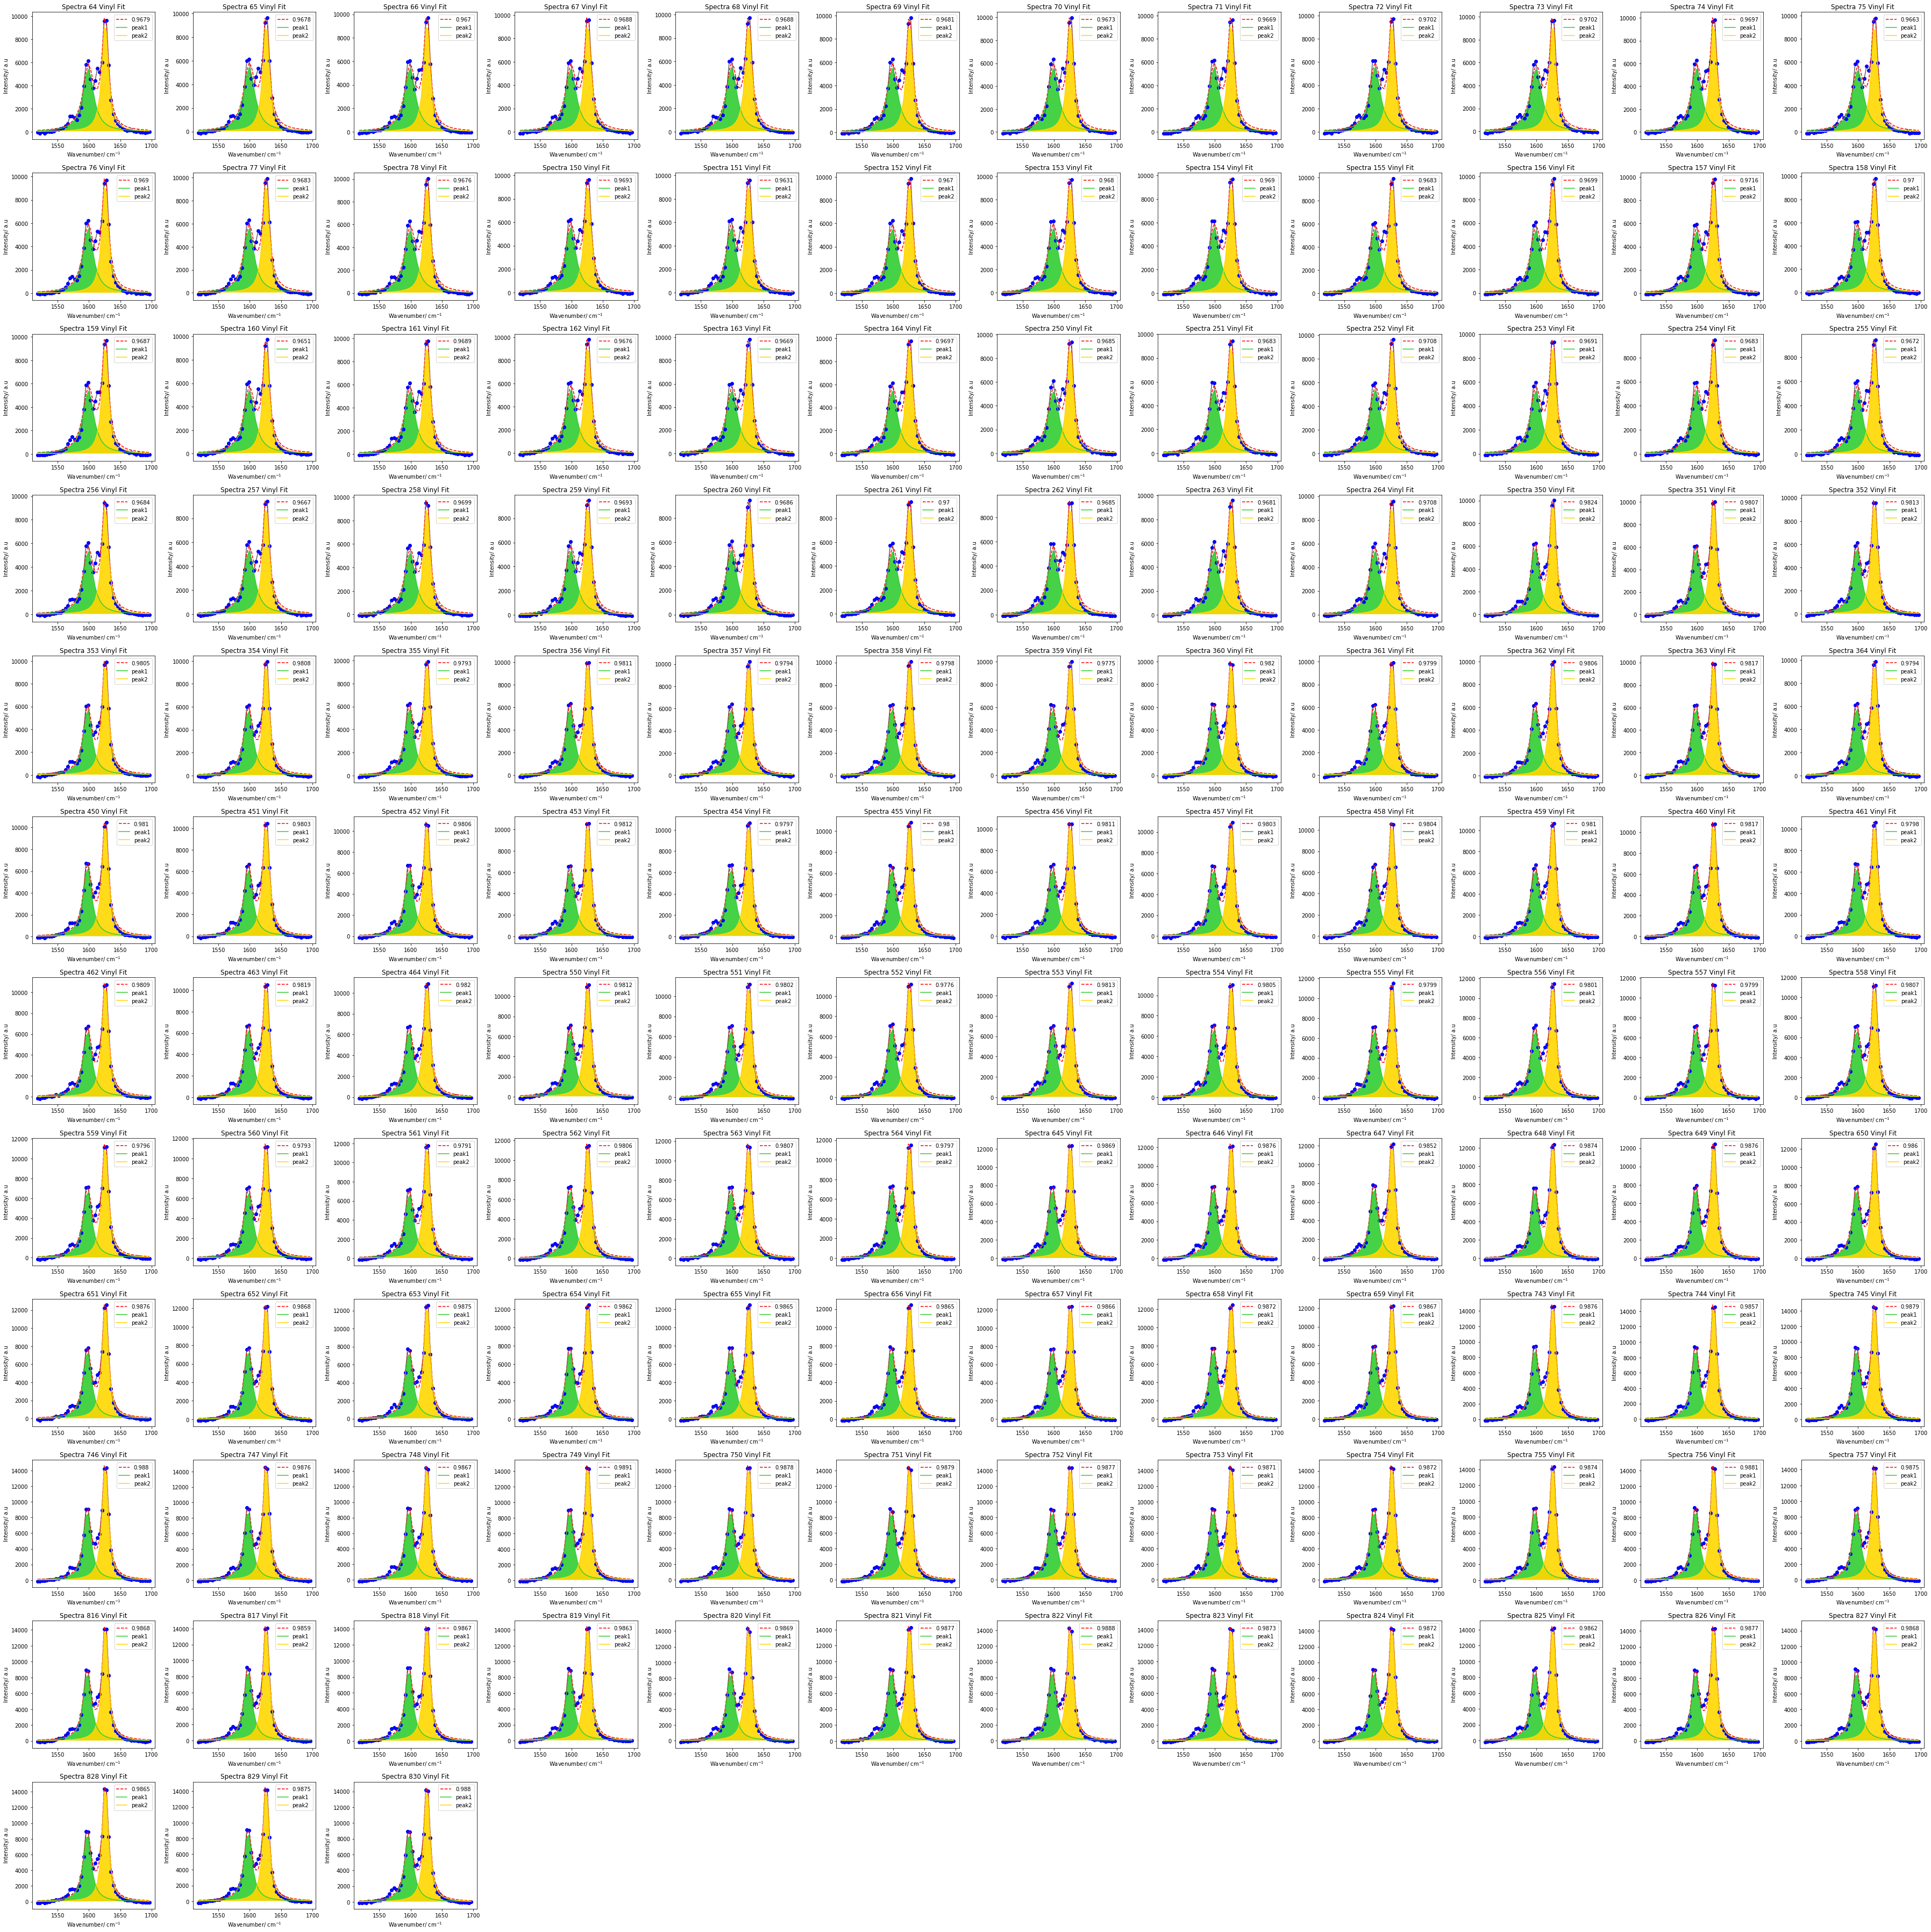

In [18]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])

pbar = tqdm(total = len(df_vinyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (50,50))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='cenL1', value = cenL1, max = 1605)
pfit.add(name='cenL2', value = cenL2, min = 1620, max = 1640)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)

for i,item in df_vinyl.iterrows():
    
    x = df_vinyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:10].values.tolist():
        xbl.append(items)

    for items in y.index[40:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:10].tolist():
        ybl.append(items)

    for items in y.values[40:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['Height_L1'] = 0.3183099*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.3183099*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    
    plt.subplot(np.ceil(np.sqrt(df_vinyl.shape[0])),np.ceil(np.sqrt(df_vinyl.shape[0])),(1+i))
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' Vinyl Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    
    pbar.update(1)
    
pbar.close()
    
plt.tight_layout()
plt.show()

In [19]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_Vinyl'}, inplace=True)
results.describe()

ampL1          ampL2        cenL1        cenL2       widL1  \
count     135.000000     135.000000   135.000000   135.000000  135.000000   
mean   180758.865344  211777.185177  1598.068948  1625.998393    8.849387   
std     16737.573124   32925.756031     0.717538     0.072622    1.260969   
min    148738.159924  168887.076963  1597.179670  1625.758486    7.353867   
25%    171001.794622  184170.513997  1597.421908  1625.953468    7.664267   
50%    178160.591414  202404.184328  1597.811345  1625.998814    8.447140   
75%    184941.890709  229986.191215  1598.860233  1626.045411   10.306408   
max    214191.433710  273037.045340  1599.577239  1626.161312   11.427548   

            widL2    R2_Vinyl     FWHM_L1     FWHM_L2    Height_L1  \
count  135.000000  135.000000  135.000000  135.000000   135.000000   
mean     5.817649    0.978665   17.698774   11.635299  6662.733367   
std      0.201426    0.007851    2.521937    0.402851  1332.025797   
min      5.479325    0.963118   14.707734   10.958650  5174.401585   
25%      5.626367    0.969493   15.328533   11.252734  5472.434648   
50%      5.830298    0.980532   16.894281   11.660595  6274.518269   
75%      5.955814    0.986613   20.612815   11.911627  7540.269041   
max      6.283225    0.989063   22.855096   12.566449  9114.476049   

          Height_L2  
count    135.000000  
mean   11649.373514  
std     2157.096243  
min     9232.149256  
25%     9680.580015  
50%    10967.854052  
75%    13086.393020  
max    15434.570252

For 2 Lorentzians peak fits within the region of interest:

In [20]:
Area_2 = pd.Series(Area_2)
labels = df.iloc[:, 0:2]
df_area = pd.concat([labels, Area_2, results['R2_Vinyl']], axis=1)
df_area.rename(columns={0: 'Vinyl Peak Area'}, inplace=True)
df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl
0                64         19    173592.826533  0.967899
1                65         19    170576.218874  0.967809
2                66         19    172197.289050  0.967028
3                67         19    174465.711386  0.968838
4                68         19    177476.897407  0.968775
..              ...        ...              ...       ...
130             826         27    251098.999993  0.987722
131             827         27    249720.440388  0.986772
132             828         27    253658.647665  0.986479
133             829         27    251428.488222  0.987455
134             830         27    249742.285333  0.988037

[135 rows x 4 columns]

# Fitting and Plotting (p-xylene Region)

In [21]:
df_pxyl = df.iloc[:, 151:180].copy()
df_pxyl.columns = df_pxyl.columns.astype('float')
df_pxyl

741.346779  745.475155  749.603622  753.730197  757.852903  761.973723  \
0         640.0       560.0       493.0       535.0       657.0       868.0   
1         663.0       565.0       539.0       554.0       611.0       909.0   
2         581.0       517.0       467.0       510.0       585.0       835.0   
3         599.0       589.0       454.0       589.0       589.0       874.0   
4         556.0       481.0       464.0       466.0       650.0       876.0   
..          ...         ...         ...         ...         ...         ...   
130       707.0       680.0       655.0       704.0       852.0      1255.0   
131       710.0       686.0       656.0       730.0       859.0      1228.0   
132       757.0       750.0       569.0       686.0       850.0      1231.0   
133       716.0       665.0       632.0       709.0       853.0      1255.0   
134       697.0       641.0       587.0       676.0       865.0      1227.0   

     766.092657  770.207731  774.320923  778.432235  ...  819.414738  \
0        1545.0      2404.0      1968.0      1216.0  ...      7769.0   
1        1598.0      2279.0      1989.0      1167.0  ...      7830.0   
2        1534.0      2328.0      1979.0      1113.0  ...      7781.0   
3        1582.0      2426.0      1950.0      1169.0  ...      7832.0   
4        1582.0      2350.0      2046.0      1091.0  ...      8047.0   
..          ...         ...         ...         ...  ...         ...   
130      2268.0      3395.0      2942.0      1587.0  ...      5821.0   
131      2237.0      3385.0      2761.0      1640.0  ...      5825.0   
132      2264.0      3371.0      2768.0      1689.0  ...      5907.0   
133      2214.0      3463.0      2804.0      1570.0  ...      5796.0   
134      2263.0      3446.0      2887.0      1627.0  ...      5972.0   

     823.497610  827.580590  831.661712  835.740978  839.816427  843.890025  \
0       12809.0     11907.0      5990.0      2445.0      1061.0       696.0   
1       12744.0     11876.0      6119.0      2319.0      1031.0       670.0   
2       12662.0     11795.0      6025.0      2367.0      1014.0       607.0   
3       12576.0     11867.0      6217.0      2312.0       995.0       653.0   
4       12668.0     11881.0      6201.0      2386.0      1019.0       722.0   
..          ...         ...         ...         ...         ...         ...   
130      9324.0      8391.0      4362.0      1892.0       972.0       741.0   
131      9081.0      8330.0      4305.0      1881.0       960.0       713.0   
132      9133.0      8314.0      4493.0      1855.0       893.0       659.0   
133      9295.0      8478.0      4324.0      1924.0       973.0       675.0   
134      9150.0      8593.0      4318.0      1879.0       927.0       676.0   

     847.959811  852.027749  856.093841  
0         484.0       406.0       419.0  
1         485.0       457.0       363.0  
2         497.0       406.0       439.0  
3         402.0       407.0       381.0  
4         461.0       376.0       362.0  
..          ...         ...         ...  
130       579.0       468.0       463.0  
131       494.0       551.0       436.0  
132       518.0       428.0       428.0  
133       502.0       469.0       449.0  
134       433.0       449.0       442.0  

[135 rows x 29 columns]

In [22]:
def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']) +
              split_lorentzian(x, pars['ampL3'], pars['cenL3'], pars['widL3'],pars['widL4']))
    
    return model - y

In [23]:
ampL1 = 14000
cenL1 = 772 
widL1 = 3

ampL2 = 27000 
cenL2 = 808
widL2 = 5

ampL3 = 100000
cenL3 = 826
widL3 = 7
widL4 = 4

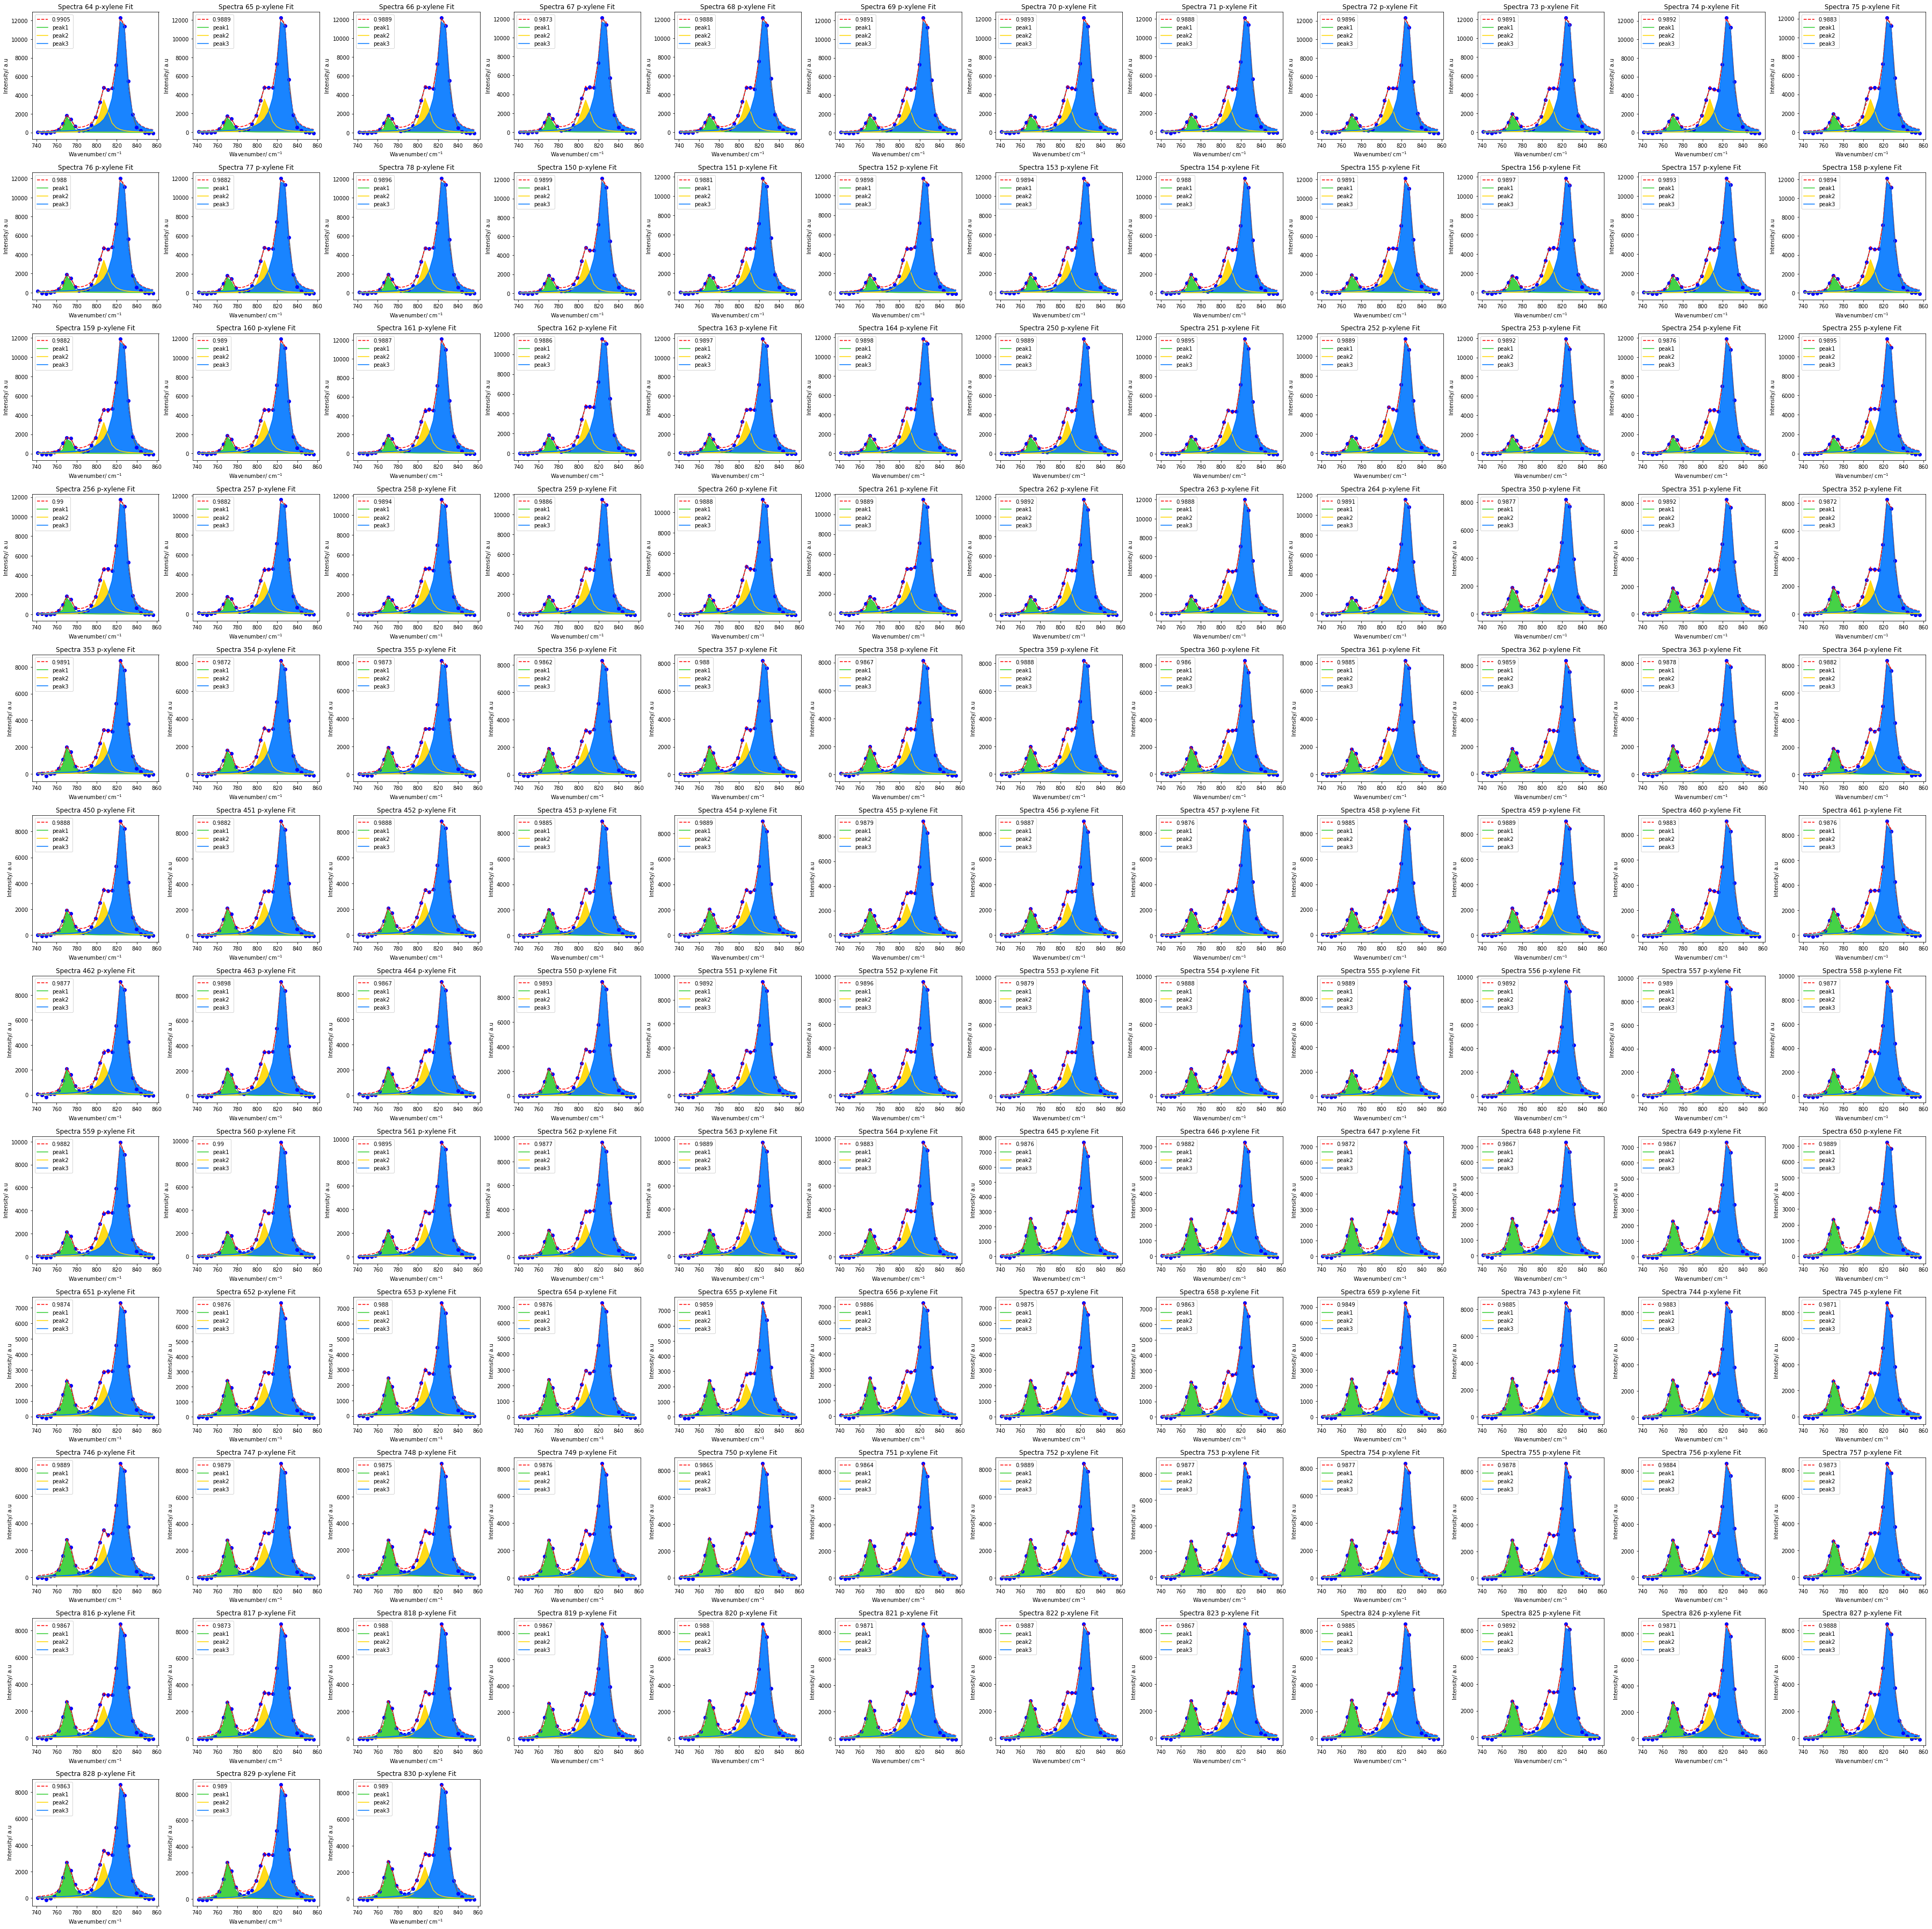

In [24]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])
Area_3 = collections.deque([])

pbar = tqdm(total = len(df_pxyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (50,50))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='ampL3', value = ampL3, min = 0)
pfit.add(name='cenL1', value = cenL1, min = 770, max = 780)
pfit.add(name='cenL2', value = cenL2, min = 805, max = 815)
pfit.add(name='cenL3', value = cenL3, min = 820, max = 830)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)
pfit.add(name='widL3', value = widL3, min = 0)
pfit.add(name='widL4', value = widL4, min = 0)

for i,item in df_pxyl.iterrows():
    
    x = df_pxyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:5].values.tolist():
        xbl.append(items)

    for items in y.index[25:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:5].tolist():
        ybl.append(items)

    for items in y.values[25:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['FWHM_L3'] = out.params.valuesdict()['widL3'] + out.params.valuesdict()['widL4']
    fit_params['Height_L1'] = 0.318309886*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.318309886*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    fit_params['Height_L3'] = 0.318309886*out.params.valuesdict()['ampL3']/max(2.220446049250313e-16, out.params.valuesdict()['widL3']+out.params.valuesdict()['widL4'])
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    peak3 = split_lorentzian(x,out.params.valuesdict()['ampL3'], out.params.valuesdict()['cenL3'], out.params.valuesdict()['widL3'], out.params.valuesdict()['widL4'])
    
    plt.subplot(np.ceil(np.sqrt(df_pxyl.shape[0])),np.ceil(np.sqrt(df_pxyl.shape[0])),(1+i))
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' p-xylene Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.plot(x, peak3,'#0077FF', label = 'peak3')
    plt.fill_between(x, peak3.min(), peak3, facecolor = '#0077FF', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    Area_3.append(integrate.simps(peak3, x))
    
    pbar.update(1)
    
plt.tight_layout()
plt.show()

In [25]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_pxyl'}, inplace=True)
results.describe()

ampL1         ampL2          ampL3       cenL1       cenL2  \
count    135.000000    135.000000     135.000000  135.000000  135.000000   
mean   25826.976444  45556.126515  178926.163443  771.487474  807.224747   
std     6955.532858   8109.856538   31682.862331    0.206787    0.230481   
min    16685.308085  32146.479546  129326.661721  770.976575  806.517038   
25%    19057.738860  39556.270723  155680.874471  771.350040  807.106758   
50%    24424.621178  43136.491728  165629.960051  771.470442  807.229828   
75%    31672.751498  53392.939276  217350.351767  771.628166  807.387218   
max    38872.872489  61089.359377  229472.017266  772.013763  807.757907   

            cenL3       widL1       widL2       widL3       widL4     R2_pxyl  \
count  135.000000  135.000000  135.000000  135.000000  135.000000  135.000000   
mean   825.778710    3.438686    5.220093    6.590750    4.284596    0.988286   
std      0.107986    0.497764    0.187195    0.224286    0.074131    0.001044   
min    825.366305    2.069428    4.708596    5.995304    4.071264    0.984927   
25%    825.707280    2.985044    5.091392    6.420166    4.233391    0.987603   
50%    825.784720    3.499030    5.219328    6.581421    4.288177    0.988473   
75%    825.859033    3.922770    5.352866    6.767650    4.328019    0.989040   
max    826.010680    4.153368    5.705633    7.202610    4.449516    0.990474   

          FWHM_L1     FWHM_L2     FWHM_L3    Height_L1    Height_L2  \
count  135.000000  135.000000  135.000000   135.000000   135.000000   
mean     6.877372   10.440186   10.875346  2358.196268  2777.915418   
std      0.995528    0.374390    0.230144   346.262188   485.941752   
min      4.138857    9.417192   10.379660  1833.293708  2022.195204   
25%      5.970089   10.182785   10.721308  2091.078943  2410.016722   
50%      6.998060   10.438655   10.847034  2255.259413  2580.776407   
75%      7.845539   10.705731   11.027744  2507.771921  3339.890332   
max      8.306737   11.411267   11.544795  3105.374995  3648.009708   

         Height_L3  
count   135.000000  
mean   5239.857965  
std     938.935124  
min    3876.716463  
25%    4569.370588  
50%    4870.498406  
75%    6400.262740  
max    6707.376255

In [26]:
df_area = pd.concat([df_area, pd.Series(Area_3), results['R2_pxyl']], axis=1)
df_area.rename(columns={0: 'pxyl Peak Area'}, inplace=True)
df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0                64         19    173592.826533  0.967899   210640.160715   
1                65         19    170576.218874  0.967809   210099.912648   
2                66         19    172197.289050  0.967028   208345.242037   
3                67         19    174465.711386  0.968838   212126.755847   
4                68         19    177476.897407  0.968775   214841.477697   
..              ...        ...              ...       ...             ...   
130             826         27    251098.999993  0.987722   143963.513758   
131             827         27    249720.440388  0.986772   146129.296947   
132             828         27    253658.647665  0.986479   148500.170024   
133             829         27    251428.488222  0.987455   145981.996423   
134             830         27    249742.285333  0.988037   152000.274047   

      R2_pxyl  
0    0.990474  
1    0.988913  
2    0.988921  
3    0.987297  
4    0.988788  
..        ...  
130  0.987119  
131  0.988845  
132  0.986251  
133  0.989049  
134  0.989015  

[135 rows x 6 columns]

In [27]:
# Keep only columns with R2 values above a threshold.
df_area = df_area[(df_area['R2_Vinyl'] > 0.96) & (df_area['R2_pxyl'] > 0.96)]

# Normalization
df_area['Vinyl Divide pxyl'] =  df_area['Vinyl Peak Area'] / df_area['pxyl Peak Area']

df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0                64         19    173592.826533  0.967899   210640.160715   
1                65         19    170576.218874  0.967809   210099.912648   
2                66         19    172197.289050  0.967028   208345.242037   
3                67         19    174465.711386  0.968838   212126.755847   
4                68         19    177476.897407  0.968775   214841.477697   
..              ...        ...              ...       ...             ...   
130             826         27    251098.999993  0.987722   143963.513758   
131             827         27    249720.440388  0.986772   146129.296947   
132             828         27    253658.647665  0.986479   148500.170024   
133             829         27    251428.488222  0.987455   145981.996423   
134             830         27    249742.285333  0.988037   152000.274047   

      R2_pxyl  Vinyl Divide pxyl  
0    0.990474           0.824120  
1    0.988913           0.811881  
2    0.988921           0.826500  
3    0.987297           0.822460  
4    0.988788           0.826083  
..        ...                ...  
130  0.987119           1.744185  
131  0.988845           1.708901  
132  0.986251           1.708137  
133  0.989049           1.722325  
134  0.989015           1.643038  

[135 rows x 7 columns]

In [28]:
# View the summary statistics
df_area_stats = df_area[['Condition', 'Vinyl Divide pxyl']].groupby('Condition').describe()
df_area_stats

Vinyl Divide pxyl                                                    \
                      count      mean       std       min       25%       50%   
Condition                                                                       
19                     15.0  0.828335  0.015641  0.811881  0.817427  0.824120   
20                     15.0  0.839453  0.018406  0.814873  0.821894  0.841498   
21                     15.0  0.834786  0.019988  0.804748  0.819779  0.835935   
22                     15.0  1.224425  0.028759  1.176253  1.205544  1.225172   
23                     15.0  1.239562  0.022986  1.204868  1.224984  1.238659   
24                     15.0  1.223910  0.015300  1.202154  1.211375  1.220873   
25                     15.0  1.739745  0.031837  1.700131  1.715490  1.736523   
26                     15.0  1.741410  0.029367  1.695711  1.720449  1.735936   
27                     15.0  1.716593  0.025728  1.643038  1.708519  1.719202   

                               
                75%       max  
Condition                      
19         0.836209  0.872300  
20         0.855279  0.864982  
21         0.847989  0.869857  
22         1.242741  1.282147  
23         1.252019  1.279421  
24         1.234158  1.252021  
25         1.752121  1.806420  
26         1.759797  1.791504  
27         1.729971  1.752011

In [29]:
mean = df_area_stats['Vinyl Divide pxyl', 'mean'].values
std = df_area_stats['Vinyl Divide pxyl', 'std'].values
condition = range(19,28)

In [30]:
df_ratio = pd.DataFrame({'Condition':condition, 'Mean Ratio':mean, 'Standard Deviation': std})
df_ratio

Condition  Mean Ratio  Standard Deviation
0         19    0.828335            0.015641
1         20    0.839453            0.018406
2         21    0.834786            0.019988
3         22    1.224425            0.028759
4         23    1.239562            0.022986
5         24    1.223910            0.015300
6         25    1.739745            0.031837
7         26    1.741410            0.029367
8         27    1.716593            0.025728

In [31]:
df_ratio.to_csv(r'C:\Users\Tan Jin Da\Desktop\High Throughput Experiments Data\201022 High Throughput Experiment Conditions 19 to 27\Online Raman\df_t90_ratio.csv')